In [30]:
import spacy
nlp = spacy.load("en_core_web_md")

In [31]:
import pandas as pd

df = pd.read_json('news_dataset.json')

In [32]:
# print the shape of the data
df.shape

(12695, 2)

In [33]:
# read the top 5 rows of json data
df.head()

,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [34]:
# check labels distribution
#df.label.value_counts()
df.category.value_counts()

BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: category, dtype: int64

In [39]:
# the data above is imbalanced and so we handle it
# using ensemble that takes the list and ignores the excess

min_samples = 1381
df_busines = df[df.category=="BUSINESS"].sample(min_samples, random_state=2000)
df_sports = df[df.category=="SPORTS"].sample(min_samples, random_state=2000)
df_crime = df[df.category=="CRIME"].sample(min_samples, random_state=2000)
df_science = df[df.category=="SCIENCE"].sample(min_samples, random_state=2000)

In [40]:
df_balanced = pd.concat([df_busines, df_sports, df_crime, df_science], axis=0)
df_balanced.category.value_counts()

BUSINESS    1381
SPORTS      1381
CRIME       1381
SCIENCE     1381
Name: category, dtype: int64

In [41]:
# adding new column label_num that gives uniquel labels

df_balanced['label_num'] = df_balanced['category'].map({
    'BUSINESS':0,
    'SPORTS':1,
    'CRIME':2,
    'SCIENCE':3,
})

# check the first five rows
df_balanced.head()

,text,category,label_num
11255,"Women in Business: Becky Taylor, Sylvan Learni...",BUSINESS,0
10793,3 Things Orgs Can Learn From How History's Big...,BUSINESS,0
2389,Shell's Arctic Ambitions Held Up in Seattle It...,BUSINESS,0
7211,Sit. Stay. Stay Away from Dog Treats from Chin...,BUSINESS,0
2763,Uber Ends Forced Arbitration In Individual Cas...,BUSINESS,0


In [42]:
#use this utility function to preprocess the text
#1. Remove the stop words
#2. Convert to base form using lemmatisation

def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    return ' '.join(filtered_tokens)

In [43]:
#create a new column "preprocessed_text" which store the clean form of given text [use apply and lambda function]

df_balanced['preprocessed_txt'] = df_balanced.text.apply(lambda x: preprocess(x))
df_balanced.head()

,text,category,label_num,preprocessed_txt
11255,"Women in Business: Becky Taylor, Sylvan Learni...",BUSINESS,0,woman business Becky Taylor Sylvan Learning Fr...
10793,3 Things Orgs Can Learn From How History's Big...,BUSINESS,0,3 thing Orgs learn history big Thinkers spend ...
2389,Shell's Arctic Ambitions Held Up in Seattle It...,BUSINESS,0,Shell Arctic Ambitions hold Seattle clear Shel...
7211,Sit. Stay. Stay Away from Dog Treats from Chin...,BUSINESS,0,sit stay stay away Dog Treats China large pet ...
2763,Uber Ends Forced Arbitration In Individual Cas...,BUSINESS,0,Uber end force Arbitration Individual case Sex...


### The Spacy Embedding for each preprocessed text

In [44]:
# store the vector representation of each preprocessed text in a new column vector

df_balanced['vector'] = df_balanced['preprocessed_txt'].apply(lambda text: nlp(text).vector)

In [45]:
# print the top five rows
df_balanced.head()

,text,category,label_num,preprocessed_txt,vector
11255,"Women in Business: Becky Taylor, Sylvan Learni...",BUSINESS,0,woman business Becky Taylor Sylvan Learning Fr...,"[-0.75378656, 0.20517392, -0.4684245, -0.68538..."
10793,3 Things Orgs Can Learn From How History's Big...,BUSINESS,0,3 thing Orgs learn history big Thinkers spend ...,"[0.28543082, 0.60603094, -1.3732622, -0.043322..."
2389,Shell's Arctic Ambitions Held Up in Seattle It...,BUSINESS,0,Shell Arctic Ambitions hold Seattle clear Shel...,"[-0.1392304, 0.49434796, -1.5088942, 0.8877268..."
7211,Sit. Stay. Stay Away from Dog Treats from Chin...,BUSINESS,0,sit stay stay away Dog Treats China large pet ...,"[-0.60878927, 0.60346854, -2.76243, 1.3408129,..."
2763,Uber Ends Forced Arbitration In Individual Cas...,BUSINESS,0,Uber end force Arbitration Individual case Sex...,"[-1.3293713, -0.49288908, -2.1482728, 2.113030..."


In [47]:
# train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    df_balanced.vector.values,
    df_balanced.label_num,
    test_size=0.2,
    random_state=2022
)

In [48]:
# reshape to 2-dimensions x_train and x_test so it fits the model
import numpy as np

x_train_2d = np.stack(x_train)
x_test_2d = np.stack(x_test)

In [50]:
print(f'before reshaping train: {x_train.shape} test: {x_test.shape}')
print(f'after reshaping train: {x_train_2d.shape} test: {x_test_2d.shape}')

before reshaping train: (4419,) test: (1105,)
after reshaping train: (4419, 300) test: (1105, 300)


In [51]:
from sklearn.metrics import classification_report

In [52]:
# using decision tree as classifier
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()

dt_clf.fit(x_train_2d, y_train)

y_pred = dt_clf.predict(x_test_2d)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.59      0.59       269
           1       0.56      0.57      0.56       291
           2       0.57      0.59      0.58       245
           3       0.59      0.56      0.58       300

    accuracy                           0.58      1105
   macro avg       0.58      0.58      0.58      1105
weighted avg       0.58      0.58      0.58      1105



* use spacy glove embeddings for text vectorization.
* use MultinomialNB as the classifier after applying the MinMaxscaler.

In [53]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

#because it won't train on a negative vector value
scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(x_train_2d)
scaled_test_embed = scaler.transform(x_test_2d)

clf = MultinomialNB()
clf.fit(scaled_train_embed, y_train)

MultinomialNB()

In [54]:

y_pred = clf.predict(scaled_test_embed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.80      0.74       269
           1       0.80      0.75      0.77       291
           2       0.80      0.86      0.83       245
           3       0.80      0.69      0.74       300

    accuracy                           0.77      1105
   macro avg       0.77      0.77      0.77      1105
weighted avg       0.77      0.77      0.77      1105



In [55]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

clf.fit(x_train_2d, y_train)

y_pred = clf.predict(x_test_2d)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.83      0.75       269
           1       0.84      0.74      0.79       291
           2       0.79      0.89      0.84       245
           3       0.84      0.68      0.75       300

    accuracy                           0.78      1105
   macro avg       0.79      0.79      0.78      1105
weighted avg       0.79      0.78      0.78      1105



In [56]:
# using decision tree as classifier
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(x_train_2d, y_train)

y_pred = rf_clf.predict(x_test_2d)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       269
           1       0.85      0.80      0.83       291
           2       0.82      0.89      0.85       245
           3       0.81      0.77      0.79       300

    accuracy                           0.82      1105
   macro avg       0.82      0.82      0.82      1105
weighted avg       0.82      0.82      0.82      1105



In [57]:
# using decision tree as classifier
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier()

gb_clf.fit(x_train_2d, y_train)

y_pred = gb_clf.predict(x_test_2d)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.82       269
           1       0.89      0.81      0.85       291
           2       0.83      0.87      0.85       245
           3       0.83      0.82      0.82       300

    accuracy                           0.83      1105
   macro avg       0.83      0.83      0.83      1105
weighted avg       0.83      0.83      0.83      1105



Text(95.72222222222221, 0.5, 'Truth')

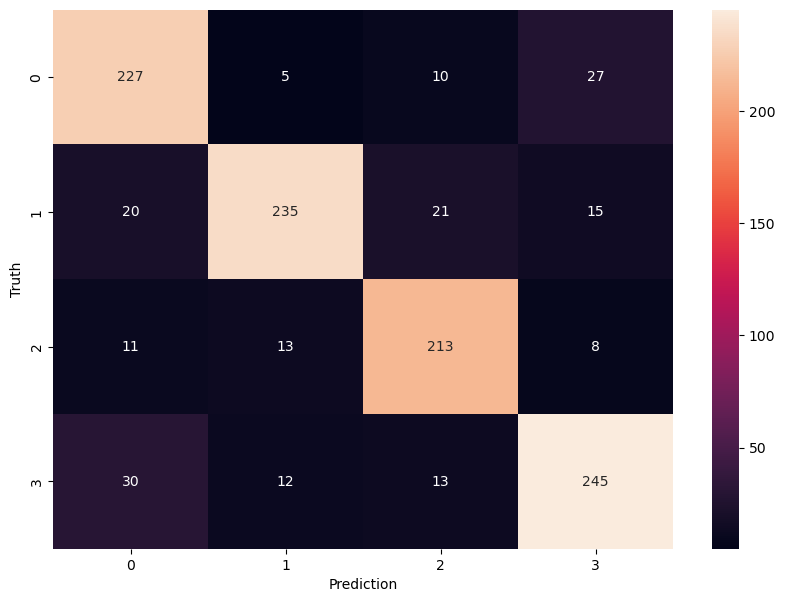

In [58]:
# Print the confusion matrix for the best model: Gradient Booster

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')